# Data Science z 3.10. GNN
## 🇬🇧 Data Science with Python 3.10. GNN
#### 👨‍🏫 PhD Wojciech Oronowicz-Jaśkowiak
#### 🤖 https://github.com/aipogodzinach

### 1. Import bibliotek
#### 🇬🇧 Import libraries
W tym miejscu importujemy biblioteki, które będą nam potrzebne do analizy danych. Jeżeli widoczny będzie błąd, to konieczne jest zainstalowanie stosowanej biblioteki w danym środowisku - wchodzimy w terminal, aktywujemy środowisko pracy, instalujemy biblioteki (np. pip install networkx).
###### Aby uruchomić ten notatnik należy skorzystać z Google Colab lub ze środowiska lokalnego z zainstalowanymi następującymi bibliotekami: torch, matplotlib, networkx.

In [1]:
%%capture

try: 
    import networkx as nx
except ModuleNotFoundError:
    !pip install networkx

try: 
    import torch
except ModuleNotFoundError:
    !pip install torch

try: 
    import torch_geometric
except ModuleNotFoundError:

    TORCH = torch.__version__.split('+')[0]
    CUDA = 'cu' + torch.version.cuda.replace('.','')

    !pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-geometric 
    import torch_geometric

import torch_geometric.nn as geom_nn
import torch_geometric.data as geom_data

from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx
from torch.nn import Linear
from torch_geometric.nn import GCNConv

### 2. Przygotowanie danych
#### 🇬🇧 Data preparation
Skorzystamy w tym miejscu ze słynnego datasetu związanego z relacjami koleżeńkimi w Klubie Karate. Zbiór nie zawiera dużo elementów i nie jest złożony. Nie musimy go ściągać i wrzucać do Dysku Google, wystarczy import z biblioteki. To, co jest jednak kluczowe z naszego punktu widzenia - każdy członek klubu należy do jednej z 4 frakcji, czyli klas jakie możemy wykorzystać w uczeniu maszynowym. Liczba wektorów wynosi 34, tyle mamy nodów w naszym zbiorze danych.
###### http://vlado.fmf.uni-lj.si/pub/networks/data/Ucinet/UciData.htm

In [2]:
dataset = KarateClub()
print(dataset)

G=nx.karate_club_graph()
print("Node Degree")
for v in G:
    print('%s %s' % (v,G.degree(v)))

KarateClub()
Node Degree
0 16
1 9
2 10
3 6
4 3
5 4
6 4
7 4
8 5
9 2
10 3
11 1
12 2
13 5
14 2
15 2
16 2
17 2
18 2
19 3
20 2
21 2
22 2
23 5
24 3
25 3
26 2
27 4
28 3
29 4
30 4
31 6
32 12
33 17


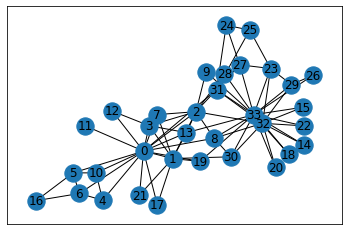

In [3]:
nx.spring_layout(G)
nx.draw_networkx(G)

In [4]:
print(nx.degree(G, 33))
print(nx.average_node_connectivity(G))
print(nx.average_shortest_path_length(G))
print(nx.average_clustering(G))

17
2.2174688057040997
2.408199643493761
0.5706384782076823


In [5]:
dataset = KarateClub()
data = dataset[0]

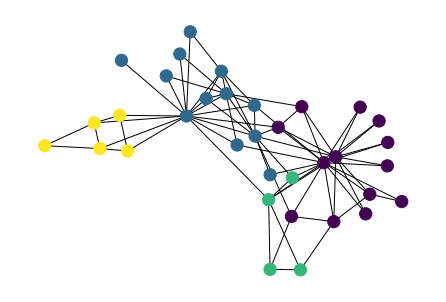

In [6]:
G = to_networkx(data, to_undirected=True)
nx.draw(G, node_color=data.y, node_size=150)

Zbliamy się powoli do przeprowadzenia częściowo nadzorowanego uczenia. Wykorzystamy za rwóno dane, które są częściowo oznaczone oraz nieoznaczone. Idea polega na tym, że nie musimy wprowadzać klasy dla każdego przypadku w naszej sieci, aby "automatycznie" oznaczyć do której klasy należałyby konkretne osoby (nody). Wykorzystamy w tym celu uczenie z wykorzystaniem sieci neuronowej, a konkretnie Graph Convolutional Networks (GCN).

In [7]:
data = dataset[0]
print(data)
print("Training nodes:", data.train_mask.sum().item()) # train mask to informacja o klasyfikacji, przynależność do klasy

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Training nodes: 4


In [8]:
data.train_mask.sum()

tensor(4)

In [9]:
data.train_mask

tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])

Zanim przejdziemy dalej, zwróćmy uwagę na jedną rzecz. Z poniższego kodu wynika, że mamy wpisane tylko cztery (!) etykiety. Czyli nasza sieć GCN będzie uczyła się przynależności poszczególnych nodów (osób) tylko na podstawie czterech przykładów - resztę sama wywnioskuje.

### 3. Architektura sieci
#### 🇬🇧 Network architecture
Przejdziemy teraz do określenia podstawowych parametrów naszej architektury GCN.

In [10]:
class GCN(torch.nn.Module):

  def __init__(self):
    super(GCN, self).__init__()
    torch.manual_seed(42)
    self.conv1 = GCNConv(34, 4) # pierwsza wartość to liczba features, czyli w naszym wypadku 34
    self.conv2 = GCNConv(4, 4)
    self.conv3 = GCNConv(4, 4)
    self.conv4 = GCNConv(4, 2)
    self.classifier = Linear(2, 4) # druga liczba odnosi się do liczby klas, czyli w naszym wypadku 4

  def forward(self, x, edge_index):
    h = self.conv1(x, edge_index)
    h = h.tanh()
    h = self.conv2(h, edge_index)
    h = h.tanh()
    h = self.conv3(h, edge_index)
    h = h.tanh()
    h = self.conv4(h, edge_index)
    h = h.tanh()
    out = self.classifier(h)
    return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 4)
  (conv4): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


In [11]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
def train(data):
  optimizer.zero_grad()
  out, h = model(data.x, data.edge_index)
  loss = criterion(out[data.train_mask], data.y[data.train_mask])
  loss.backward()
  optimizer.step()
  return loss, h
epochs = range(1, 500)
losses = []
embeddings = []
for epoch in epochs:
  loss, h = train(data)
  losses.append(loss)
  embeddings.append(h)
  print(f"Epoch: {epoch}\tLoss: {loss:.4f}")

Epoch: 1	Loss: 1.4497
Epoch: 2	Loss: 1.4310
Epoch: 3	Loss: 1.4144
Epoch: 4	Loss: 1.3995
Epoch: 5	Loss: 1.3861
Epoch: 6	Loss: 1.3741
Epoch: 7	Loss: 1.3632
Epoch: 8	Loss: 1.3533
Epoch: 9	Loss: 1.3441
Epoch: 10	Loss: 1.3356
Epoch: 11	Loss: 1.3274
Epoch: 12	Loss: 1.3193
Epoch: 13	Loss: 1.3110
Epoch: 14	Loss: 1.3023
Epoch: 15	Loss: 1.2928
Epoch: 16	Loss: 1.2824
Epoch: 17	Loss: 1.2709
Epoch: 18	Loss: 1.2581
Epoch: 19	Loss: 1.2437
Epoch: 20	Loss: 1.2276
Epoch: 21	Loss: 1.2097
Epoch: 22	Loss: 1.1901
Epoch: 23	Loss: 1.1691
Epoch: 24	Loss: 1.1471
Epoch: 25	Loss: 1.1239
Epoch: 26	Loss: 1.0992
Epoch: 27	Loss: 1.0727
Epoch: 28	Loss: 1.0449
Epoch: 29	Loss: 1.0167
Epoch: 30	Loss: 0.9887
Epoch: 31	Loss: 0.9609
Epoch: 32	Loss: 0.9336
Epoch: 33	Loss: 0.9074
Epoch: 34	Loss: 0.8828
Epoch: 35	Loss: 0.8596
Epoch: 36	Loss: 0.8375
Epoch: 37	Loss: 0.8167
Epoch: 38	Loss: 0.7974
Epoch: 39	Loss: 0.7795
Epoch: 40	Loss: 0.7625
Epoch: 41	Loss: 0.7463
Epoch: 42	Loss: 0.7312
Epoch: 43	Loss: 0.7169
Epoch: 44	Loss: 0.70

In [12]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/')

Mounted at /content/drive


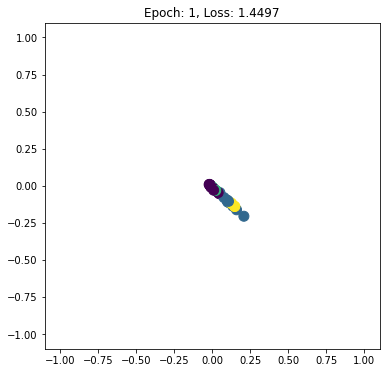

In [13]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

def animate(i):
  ax.clear()
  h = embeddings[i]
  h = h.detach().numpy()
  ax.scatter(h[:, 0], h[:, 1], c=data.y, s=100)
  ax.set_title(f'Epoch: {epochs[i]}, Loss: {losses[i].item():.4f}')
  ax.set_xlim([-1.1, 1.1])
  ax.set_ylim([-1.1, 1.1])
fig = plt.figure(figsize=(6, 6))
ax = plt.axes()
anim = animation.FuncAnimation(fig, animate, frames=200)
plt.show()
gif_writer = animation.PillowWriter(fps=20)
anim.save('animacja2.gif', writer=gif_writer)

### 📚 Zadania
1. Zmodyfikuj zapoproponowaną architekturę zmieniając liczbę warstw sieci (na przykład do trzech), zapisz ją jako "model_2", porównaj wyniki z pierwszym modelem.
2. Wykorzystaj architekturę zaproponowaną w czasie zajęć, nie modyfikuj jej, ale sprawdź dwie inne, wybrane przez siebie, wartość współczynnika uczenia się (np. lr = 0.02). Czy udało Ci się osiągnąć lepsze parametry modelu bez zmiany liczby epok?
3. Zmień funkcję aktywacji z ostatniej warstwy sieci na funkcję sigmoidalną. Porównaj animację ilustrującą przebieg uczenia się w przypadku tej funkcji w porównaniu do tangensa hiperbolicznego. Dlaczego funkcja sigmoidalna jest bez sensu w naszym wypadku, ale jest mozliwa do policzenia?

In [15]:
class GCN2Sigm(torch.nn.Module):

  def __init__(self):
    super(GCN2Sigm, self).__init__()
    torch.manual_seed(42)
    self.conv1 = GCNConv(34, 4) # pierwsza wartość to liczba features, czyli w naszym wypadku 34
    self.conv2 = GCNConv(4, 4)
    self.conv3 = GCNConv(4, 4)
    self.conv4 = GCNConv(4, 2)
    self.classifier = Linear(2, 4) # druga liczba odnosi się do liczby klas, czyli w naszym wypadku 4

  def forward(self, x, edge_index):
    h = self.conv1(x, edge_index)
    h = h.sigmoid()
    h = self.conv2(h, edge_index)
    h = h.sigmoid()
    h = self.conv3(h, edge_index)
    h = h.sigmoid()
    h = self.conv4(h, edge_index)
    h = h.sigmoid()
    out = self.classifier(h)
    return out, h

model = GCN2Sigm()
print(model)

GCN2Sigm(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 4)
  (conv4): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


In [16]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
def train(data):
  optimizer.zero_grad()
  out, h = model(data.x, data.edge_index)
  loss = criterion(out[data.train_mask], data.y[data.train_mask])
  loss.backward()
  optimizer.step()
  return loss, h
epochs = range(1, 500)
losses = []
embeddings = []
for epoch in epochs:
  loss, h = train(data)
  losses.append(loss)
  embeddings.append(h)
  print(f"Epoch: {epoch}\tLoss: {loss:.4f}")

Epoch: 1	Loss: 1.4471
Epoch: 2	Loss: 1.4379
Epoch: 3	Loss: 1.4295
Epoch: 4	Loss: 1.4217
Epoch: 5	Loss: 1.4145
Epoch: 6	Loss: 1.4081
Epoch: 7	Loss: 1.4022
Epoch: 8	Loss: 1.3970
Epoch: 9	Loss: 1.3923
Epoch: 10	Loss: 1.3882
Epoch: 11	Loss: 1.3845
Epoch: 12	Loss: 1.3812
Epoch: 13	Loss: 1.3783
Epoch: 14	Loss: 1.3758
Epoch: 15	Loss: 1.3736
Epoch: 16	Loss: 1.3717
Epoch: 17	Loss: 1.3700
Epoch: 18	Loss: 1.3684
Epoch: 19	Loss: 1.3671
Epoch: 20	Loss: 1.3659
Epoch: 21	Loss: 1.3648
Epoch: 22	Loss: 1.3638
Epoch: 23	Loss: 1.3628
Epoch: 24	Loss: 1.3619
Epoch: 25	Loss: 1.3610
Epoch: 26	Loss: 1.3602
Epoch: 27	Loss: 1.3593
Epoch: 28	Loss: 1.3585
Epoch: 29	Loss: 1.3576
Epoch: 30	Loss: 1.3568
Epoch: 31	Loss: 1.3559
Epoch: 32	Loss: 1.3550
Epoch: 33	Loss: 1.3540
Epoch: 34	Loss: 1.3530
Epoch: 35	Loss: 1.3520
Epoch: 36	Loss: 1.3510
Epoch: 37	Loss: 1.3499
Epoch: 38	Loss: 1.3488
Epoch: 39	Loss: 1.3476
Epoch: 40	Loss: 1.3464
Epoch: 41	Loss: 1.3452
Epoch: 42	Loss: 1.3440
Epoch: 43	Loss: 1.3427
Epoch: 44	Loss: 1.34

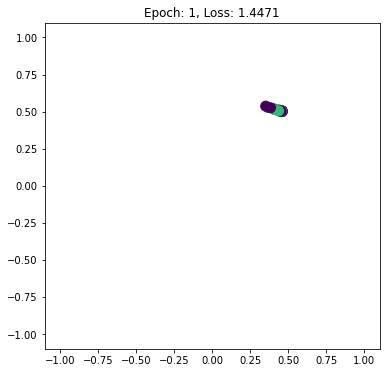

In [17]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes()
anim = animation.FuncAnimation(fig, animate, frames=200)
plt.show()
gif_writer = animation.PillowWriter(fps=20)
anim.save('animacja2_sigmoid.gif', writer=gif_writer)

### 📚 Tasks
1. Modify the proposed architecture by changing the number of network layers (for example to 3), save it as "model_2", compare the results with the first model.
2. Use the proposed architecture , do not modify it, but modify the learning rate (for example lr = 0.02). Did you achieve better model?
3. Change the activation function from the last layer of the network to a sigmoidal function. Compare the animation for this function learning. Why is the sigmoidal function pointless in our case?